# 00 ColaboratoryでChainerを動かしてみよう

Chainer Begginer's Hands-onの最初のNotebookをご覧いただきありがとうございます。

このNotebookの目的は以下の通りです。

* ColaboratoryでPython、Notebookの操作のおさらい
* ColaboratoryでChainerを使うための設定
* Chainerで衣類の画像を分類してみよう


## ColaboratoryでPython、Notebookの操作のおさらい

* [Colaboratory の概要](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

詳しいColaboratory の機能については[こちら](https://colab.research.google.com/notebooks/welcome.ipynb)

## ColaboratoryでChainerを使うための設定

### 必要なライブラリ・Chainer・CuPyのインストール

下記のスクリプト内では、GPUを動かすのに必要なパッケージのインストール、Chainerのインストール、cudaのバージョンに応じたCuPyのインストールが行われています。

本来なら適切なバージョンの**CuPyをインストールする必要があります。**しかし、上記スクリプトはColaboratoryにインストールされているcudaのバージョンを見て、自動的に適切なCuPyをインストールします。

In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0   4722      0 --:--:-- --:--:-- --:--:--  4722
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-npp-dev-9-2
  cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
The following NEW packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-libraries-dev-9-2
  cuda-npp-dev-9-2 cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
0 upgraded, 9 newly installed, 0 to remove and 12 not upgraded.
Need to get 332 MB of archives.
After this operation, 972 MB of additional disk space will be used.
Get:1 https://develo

Chainer v4.0.0から`chainer.print_runtime_info()`という便利なメソッドが追加されました。以下のコマンドをターミナルで実行し、ChainerやCuPyが正しくインストールされたかを確認してみましょう。

In [2]:
!python -c 'import chainer; chainer.print_runtime_info()'

Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 4.5.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 4.5.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213


うまくインストールできていますね。以下のチュートリアルでは、matplotlibを可視化に使いますので、これも同時にインストールしておきましょう。

In [3]:
!pip install matplotlib

また、計算グラフの可視化にGraphvizを使いますので、こちらもインストールしておいてください。

In [4]:
!apt -y -qq install graphviz > /dev/null 2> /dev/null
!pip install pydot

    100% |████████████████████████████████| 133kB 7.8MB/s 
  Running setup.py bdist_wheel for pydot ... - done
  Stored in directory: /root/.cache/pip/wheels/6a/a5/14/25541ebcdeaf97a37b6d05c7ff15f5bd20f5e91b99d313e5b4
Successfully built pydot


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import chainer

## Chainerで衣類の画像を分類してみよう
では、早速Chainerをつかってどんな機械学習の問題を解けるか試してみましょう！

今回解く問題は、スニーカー、Tシャツのような、白黒の衣類の画像を分類する問題です。

![fashion mnist](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

上記は、[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)というデータセットで、[Zalando](http://www.zalando.com/)というファッション記事のデータベースから作成されています。

Fashion-MNISTは、皆さんがご存知の[MNIST](https://en.wikipedia.org/wiki/MNIST_database)と同じ性質を持つ、置き換え可能なデータセットです。Fashion-MNISTはMNISTに比べて分類する難易度が高い、互換性を有するデータセットいうことができるでしょう。

* 60,000枚の訓練用画像と、10,000枚のテスト用画像を含む。
* 各画像は縦横28x28のグレースケール画像(784次元ベクトル)。
* それぞれの画像には0から9までの正解ラベルIDが与えられている。

この問題で解くべきタスクは、与えられた画像のラベルIDを予測することであり、10クラス分類問題に相当します。




ラベルは、0から9までのIDで表現されており、それぞれ以下を意味します。

* 0 : T-shirt/top (Tシャツ)
* 1 : Trouser (ズボン)
* 2 : Pullover (パーカー)
* 3 : Dress (ドレス)
* 4 : Coat (コート)
* 5 : Sandal (サンダル)
* 6 : Shirt (シャツ)
* 7 : Sneaker (スニーカー)
* 8 : Bag (バッグ)
* 9 : Ankle boot (アンクルシューズ)

あとで使用するために、ラベルID ``label``からラベル名を取得する関数``get_label_name``をここで定義しておきましょう。

In [0]:
LABEL_NAMES = [
    'T-shirt/top', 
    'Trouser',
    'Pullover',
    'Dress',
    'Coat', 
    'Sandal', 
    'Shirt',
    'Sneaker',
    'Bag', 
    'Ankle boot'
]

def get_label_name(label):
    return LABEL_NAMES[label]

In [7]:
print('0 is ', format(get_label_name(0)))

0 is  T-shirt/top


### データセットの中身を見てみよう
では、早速データセットをダウンロードし、その中身を見てみましょう。

教師あり学習の場合、**データセットは「入力データ」と「それと対になるラベルデータ」をタプルで返すオブジェクトである必要があります。**

ChainerにはMNISTやCIFAR10/100のようなよく用いられるデータセットに対して、データをダウンロードしてくるところからそのような機能をもったオブジェクトを作るところまで自動的にやってくれる便利なメソッドがあります。

Fashion-MNISTにも用意されているので、ここではひとまずこれを使いましょう。

In [8]:
from chainer.datasets.fashion_mnist import get_fashion_mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = get_fashion_mnist(withlabel=True, ndim=1)

下記を実行して、データセットのサイズを確認しましょう。

上で説明したように、訓練用データは60,000、テスト用データは10,000でしょうか。

In [9]:
print('Size of train', len(train))
print('Size of test', len(test))

Size of train 60000
Size of test 10000


では、テスト用データの1つ目の中身を見てみましょう。``x``は784次元のベクトルになっているはずです。

また、ラベルは9で、それは「Ankle boot」だとわかります。


In [10]:
x, t = test[0]
print('Shape of x:', x.shape)
print('label:', t)
print('label name:', get_label_name(t))

Shape of x: (784,)
label: 9
label name: Ankle boot


本当に「Ankle boot」なのか確かめたいですよね。試しに``plt.plot``を使ってplotしてみましょう。

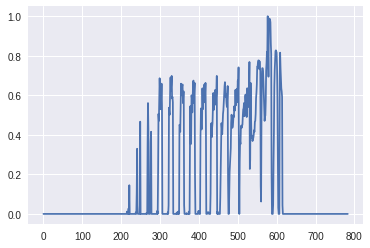

In [11]:
plt.plot(x)

しかし、これだと0.0から1.0の値をとっていることはわかりますが、何なのかわかりません。

画像として表示するためには、``plt.imshow``というものがあるのでこれを使ってみましょう。画像として表示するためには2次元配列に直す必要があるので、``reshape``しています。

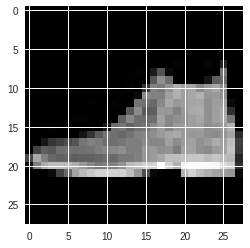

In [12]:
plt.imshow(x.reshape(28, 28), cmap='gray')

せっかくなので、それぞれのラベルの画像を表示してみましょう。

0 T-shirt/top


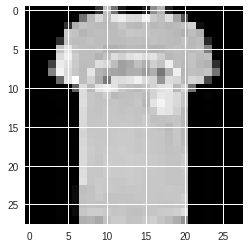

1 Trouser


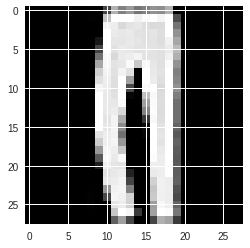

2 Pullover


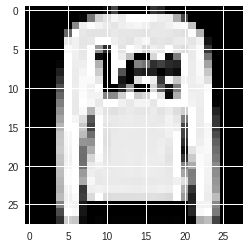

3 Dress


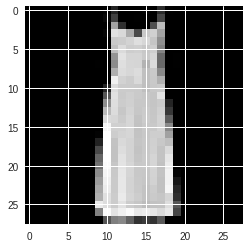

4 Coat


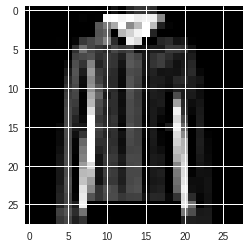

5 Sandal


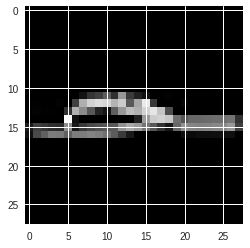

6 Shirt


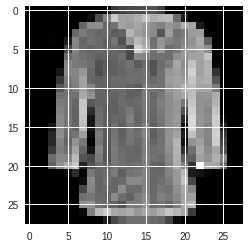

7 Sneaker


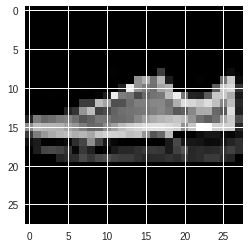

8 Bag


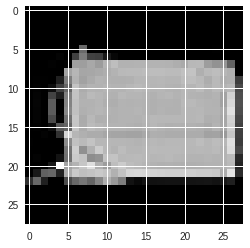

9 Ankle boot


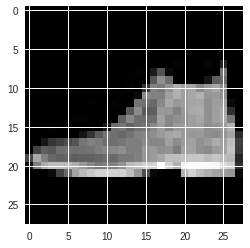

In [13]:
for label_name in LABEL_NAMES:
    this_data = ((x,t) for x, t in test if get_label_name(t) == label_name)  # generator
    x, t = next(this_data)
    print(t, label_name)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.show()

### 訓練データの分割
機械学習のモデルを評価するためには、訓練用データだけでなく、未知のデータに対する性能を評価するためのテスト用データが必要です。機械学習では、まだ見たことのない未知のデータに対してモデルが正しい結果を出力する必要があります。そのため、テスト用データを擬似的に未知のデータとして扱い、未知のデータに対する性能を評価します。

つまり、この段階で最低でも3つのデータに対する分類が存在します。

* 訓練用データ(train data)：モデルの訓練に使用するデータ。
* テスト用データ(test data)：モデルの未知のデータに対する性能を評価するデータ。
* 未知のデータ：モデルを運用したときに遭遇するデータ。モデルを作るときには存在しない。

ただし、モデルを訓練するとき、モデルの訓練とテストを1度だけ行って「お、テストでも性能が良かったからこれで終わり！」となることはありえません。なので、モデルのパラメータチューニングや比較を行う繰り返し行う必要があります。

その際に、テスト用データを使ってパラメータチューニングや比較を行うことはできません。なぜなら、パラメータチューニングや比較にテスト用データを使ってしまうと、その時点でテスト用データはモデルにとって未知のデータではなくなってしまうからです。

直感的な説明になってしまいますが、これらのデータを資格試験や入学試験にたとえてみようと思います。試験を受ける場合、基本的には以下のような段階を踏むと思います。

1. テキストを読んで練習問題を解く
2. ある程度練習問題が解けてきたら模擬試験の問題を解く
3. 最後に本番の試験の問題を解く

なんとなくですが、1の問題は「訓練用データ」、3の問題は「まだ見たことのない未知のデータ」と例えられそうです。2の問題は、その人の合格確率(性能)を評価するという意味でテスト用データということができます。この時、パラメータチューニングや比較にテスト用データを使うというのはどういうことかというと、同じ模擬試験で何度も合格確率を評価するということを意味します。何度も同じ問題で合格率を評価すると、不当に合格率が高くなってしまうでしょう。それと同じ問題が機械学習でも発生します。

つまり、どういうことかというと、訓練用データ、テスト用データだけでなく、パラメータチューニングをするための検証用データが訓練時には必要になります。

* 訓練用データ(train data)：モデルのトレーニングに使用するデータ。
* **検証用データ(validation data)**：最適なパラメータのモデルを選択するためのデータ。訓練用データを使って複数のパラメータでトレーニングした後、このデータを使ってモデルの性能を検証し、最も良いモデルを選択する。
* テスト用データ(test data)：選択したモデルの未知のデータに対する性能を評価するデータ。
* 未知のデータ：モデルを運用したときに遭遇するデータ。モデルを作るときには存在しない。

上記の通り、検証用データも必要になるので、``train``を``train``と``validation``に分割しましょう。Chainerにはデータセットを分割するために[split_dataset_random](https://docs.chainer.org/en/stable/reference/generated/chainer.datasets.split_dataset_random.html)という関数が用意されています。60,000個の``train``を50,000個の``train``と10,000個の``validation``に分割しましょう。

In [0]:
train, validation = chainer.datasets.split_dataset_random(train, 50000, seed=0)

#### 課題
- 上記の文脈で、下記の言葉がどのような意味か調べて、説明を書いてみましょう。

    1. **モデル選択**
    2. **汎化誤差**、**汎化性能**
    3. **過学習**
    4. **交差検証**

### はじめてのモデルをトレーニングしよう

最も単純なニューラルネットワークモデルとして、2層の多層パーセプトロン（MLP2）を作ってみましょう。これは入力と出力、およびその間に1つの隠れユニットを持ちます。2つの線形レイヤー（全結合層）がそれらの間にあり、それぞれ重み行列とバイアス項をパラメータとして内蔵しています。隠れユニットに対する活性化関数はtanhを用います。

![MLP2](https://raw.githubusercontent.com/chainer-community/chainer-colab-notebook/master/docs/mlp.png)

以下がMLP2を実装したクラスです。コンストラクタ(``__init__``)の中では各レイヤーの種類と大きさしか定義していないことに注意してください。実際の計算は別の``__call__``メソッド内に直接書かれています。

In [0]:
import chainer.functions as F
import chainer.links as L
from chainer import Chain

class MLP2(Chain):

    # Initialization of layers
    def __init__(self):
        super(MLP2, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)  # From 784-dimensional input to hidden unit with 200 nodes
            self.l2=L.Linear(200, 10)  # From hidden unit with 200 nodes to output unit with 10 nodes  (10 classes)

    # Forward computation by __call__
    def __call__(self, x):
        h1 = F.tanh(self.l1(x))  # Forward from x to h1 through activation with tanh function
        y = self.l2(h1)  # Forward from h1to y
        return y

ここで、作成したモデルを訓練し、検証を行う関数``train_and_validate``を定義します。以降でモデルをいくつか作りますが、全てこの関数で訓練と検証を行うことができます。簡単に中身を見てみましょう。以下のような工程を行っています。

1. 与えられた``enable_cupy``の値に応じて、CPUで訓練するか、GPUで訓練するか決める。
2. 与えられた``optimizer``に``model``を設定する
3. 与えられた訓練用データ``train``、検証用データ``validation``からそれぞれIteratorを作成する
4. Updater・Trainerを作成する
5. Trainerの機能を拡張する
    1. ログ出力を行う
    2. 検証用データの計算を行う
    3. 標準出力に指定した指標を表示する
    4. 画像として損失関数の値を保存する
    5. 画像として精度を保存する
6. 訓練を開始する

ここではChainerの様々な機能を使っています。なんでこんな事ができるのだろう？、他にどのようなことができるのだろう？と疑問に思うかもしれませんが、次回以降のハンズオンで説明を行います。ただ、どうしても今すぐ知りたい方は[Chainer v4 ビギナー向けチュートリアル](https://qiita.com/mitmul/items/1e35fba085eb07a92560)を参照してみてください。

In [0]:
from chainer import optimizers, training
from chainer.training import extensions

def  train_and_validate(
        model, optimizer, train, validation, n_epoch, enable_cupy, batchsize):
    
    # 1. cpu/gpuを決める
    device = -1
    if enable_cupy:
        device = 0
        chainer.backends.cuda.get_device_from_id(device).use()
        model.to_gpu()
        
    # 2. Optimizerを設定する
    optimizer.setup(model)
    
    # 3. DatasetからIteratorを作成する
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    validation_iter = chainer.iterators.SerialIterator(
        validation, batchsize, repeat=False, shuffle=False)
    
    # 4. Updater・Trainerを作成する
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='out')
    
    # 5. Trainerの機能を拡張する
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(validation_iter, model, device=device), name='val')
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'val/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    
    # 6. 訓練を開始する
    trainer.run()

最初の実験として、CPUで訓練を行います。エポック数（``n_epoch``、各サンプルが訓練中に何度使われるか）は5に固定します。

また、ミニバッチサイズ（``batchsize``、一度のパラメータ更新に何サンプルを損失関数の計算に用いるか）は256を使用します。


[L.Classifier](https://github.com/pfnet/chainer/blob/master/chainer/links/model/classifier.py) はニューラルネットワーク（ここではMLP2）を内蔵した分類モデルです。デフォルトの損失関数はSoftmax cross entropyです。MLP2を分類モデルにするため使用します。

Optimizerはモデルのパラメータ（ここではMLP2中の線形レイヤー中の重み行列とバイアス項）を更新するために使われます。Chainerはよく使われる最適化アルゴリズムの多くを[サポート](http://docs.chainer.org/en/stable/reference/optimizers.html#optimizers) しています(SGD, AdaGrad, RMSProp, Adam, etc...)。ここではSGDを使用します。


In [0]:
enable_cupy = False  # No CuPy (Use NumPy)
n_epoch = 5  # Only 5 epochs
batchsize = 256

model = MLP2() # MLP2 model
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()

``train_and_validate``を実行して、モデルの訓練と検証を行いましょう。

In [18]:
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, enable_cupy, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.38483     0.61089        1.03066        0.677344           2.56369       
2           0.907157    0.71228        0.836532       0.725977           5.50534       
3           0.777443    0.749619       0.749766       0.747559           8.44866       
4           0.70816     0.770448       0.696757       0.765723           11.4804       
5           0.660491    0.785677       0.658026       0.777734           14.4313       


検証用データにおける精度（val/main/accuracy）は78%に届かない程度だと思います。まだまだ精度は良くないので、今後の実験で精度向上を目指しましょう。

Chainerは入力から損失関数までの計算グラフを出力できます。``display_graph``はそのために定義した関数です。

In [0]:
import pydot
from IPython.display import Image, display

def display_graph():
    graph = pydot.graph_from_dot_file('out/cg.dot') # load from .dot file
    graph[0].write_png('graph.png')
    display(Image('graph.png', width=600, height=600))

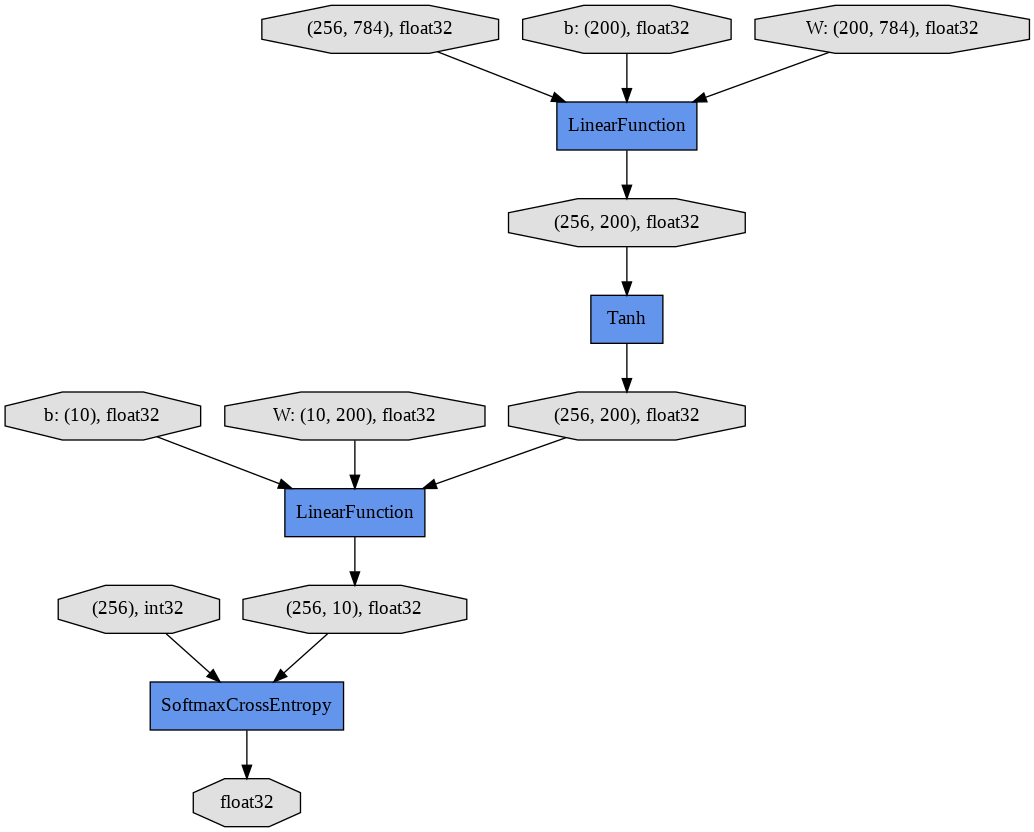

In [20]:
display_graph()

``display_graph``を実行することで、有向グラフが表示されます。一番上の3つの楕円形がそれぞれ784次元の画像256サンプル、線形レイヤーの対応する784x200の大きさの重み行列、長さ200のバイアス項ベクトル、を表します。

中間の隠れユニット（256x200）は活性化関数tanhを通して次の線形レイヤーの入力となります。ニューラルネットワークの出力である長さ10の256ベクトルは正解であるint32のリストと比較され、``SoftmaxCrossEntropy``関数によって損失がfloat32の値として算出されます。

extentionにより画像として保存した損失と、精度を表示してみましょう。

In [0]:
def plot_loss_and_accuracy():
    display(Image(filename='out/loss.png'))
    display(Image(filename='out/accuracy.png'))

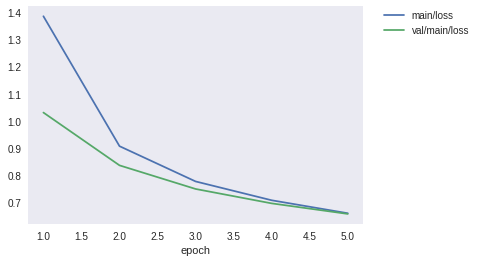

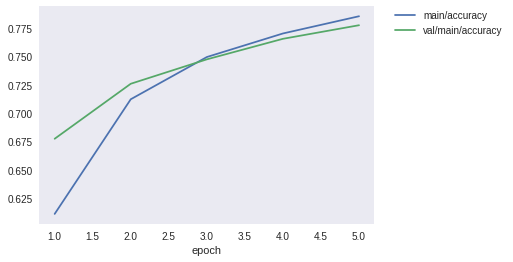

In [22]:
plot_loss_and_accuracy()

上記を見ると、エポックごとに損失は減少し、精度は向上していることがわかると思います。また、グラフとして可視化することによって、エポック数を増やすことによってまだまだ性能は改善しそうなことがわかると思います。ここに性能を可視化するメリットがあります。

テスト用データセットのFashion-MNIST画像60サンプルをプロットします。画像上部の「Answer」がデータセットで与えられた正解であり、「Predict」が現在の分類モデルによる予測結果です。

In [0]:
from chainer import Variable

def plot_examples(model, test, enable_cupy):
    plt.figure(figsize=(12,50))
    if enable_cupy:
        model.to_cpu()
    for i in range(45, 105):
        data, label = test[i]  # test data, label
        x = Variable(np.asarray([data]))  
        t = Variable(np.asarray([label]))  # labels
        y = model(x)
        prediction = y.data.argmax(axis=1)
        example = (data * 255).astype(np.int32).reshape(28, 28)
        plt.subplot(20, 5, i - 44)
        plt.imshow(example, cmap='gray')
        plt.title("No.{0}\nAnswer:{1}\nPredict:{2}".format(
            i,
            get_label_name(label),
            get_label_name(prediction[0])
        ))
        plt.axis("off")
    plt.tight_layout()

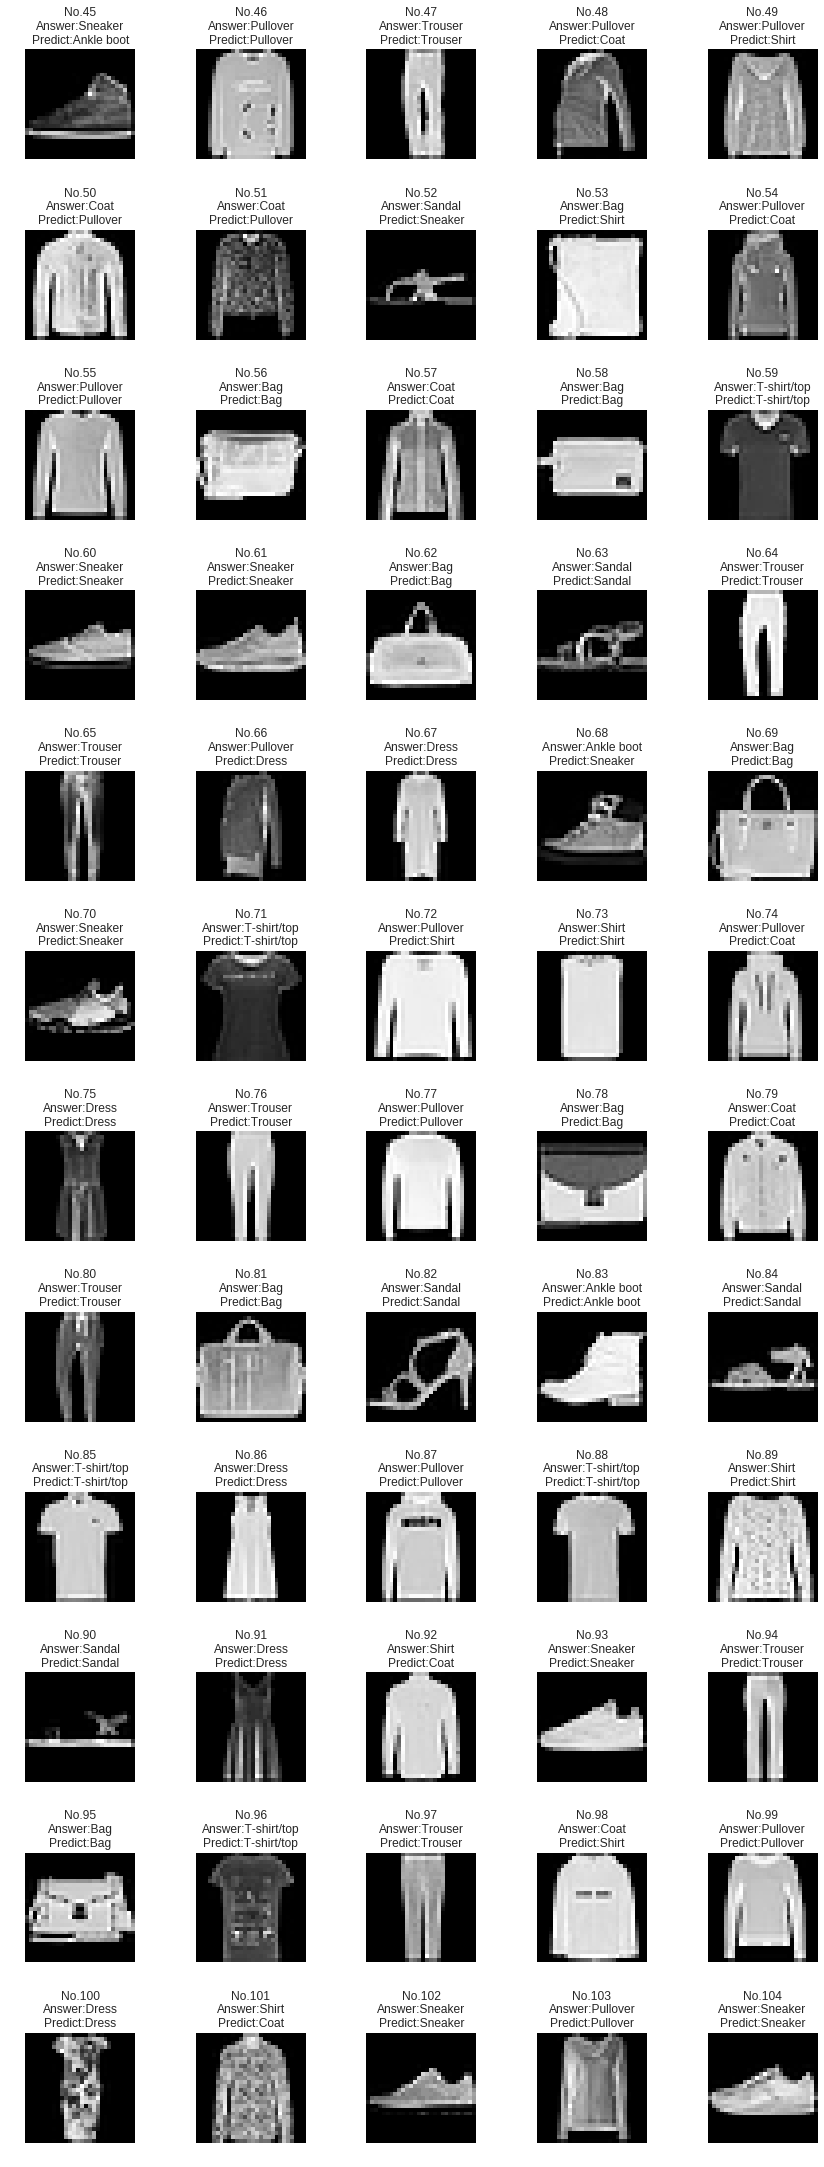

In [24]:
plot_examples(model, test, enable_cupy)

多くのサンプルは正しく分類されていますが、誤りも見受けられます。例えば、1行目のNo. 45の画像が「Ankle boot」と予測されているとおもいますが、正解は「Sneaker」です。また、6行目のNo. 72の画像が「T-shirt/top」と予測されているとおもいますが、正解は「Pullover」です。

最後に、本当に未知のデータでも性能を発揮するか、テスト用データにおける精度も評価してみましょう。テスト用データでの精度を表示する関数``print_test_performance``をここで定義します。

In [0]:
def print_test_performance(model, test, enable_cupy, batchsize):
    device = -1
    if enable_cupy:
        model.to_gpu()
        device = 0
    test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
    test_evaluator = extensions.Evaluator(test_iter, model, device=device)
    results = test_evaluator()
    print('Test accuracy:', results['main/accuracy'])

In [26]:
print_test_performance(classifier_model, test, enable_cupy, batchsize)

Test accuracy: 0.7798828125


78%弱ということで、検証用データにおける精度とほぼ同じ精度を未知のデータでも達成できていることがわかります。

「はじめてのモデルをトレーニングしよう」はいかがだったでしょうか。この1連の手順を行うことで、機械学習のモデルを作ることができます。この後は、この手順をGPUを用いて高速化したり、モデルの性能を向上させたりしていきましょう！

### CuPyでGPUを計算に使って学習を高速化してみよう

上記の実験では、エポック数5で13秒程度かかっていることがわかります。

次の実験では、CuPyを有効にしてGPUを使うことでこの訓練を高速化してみましょう。

In [27]:
enable_cupy = True
n_epoch = 5
batchsize = 256

model = MLP2()
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, enable_cupy, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.43484     0.605628       1.04609        0.671191           7.388         
2           0.916951    0.705689       0.84338        0.717578           9.12013       
3           0.783432    0.743389       0.754289       0.744824           10.8253       
4           0.712557    0.766004       0.699757       0.764355           12.5778       
5           0.666084    0.781611       0.662205       0.777832           14.3312       


同じモデルをGPUで訓練した場合の実行時間を比べると、この環境ではGPUによる訓練はCPUに比べて2/3程度になります。ただ、計算時間は以下の状況等によって変化します。

* GPU機種：基本的に新機種ほど、GPUのスペックが良いので、計算時間が速くなる。
* batchsize：値が大きいほど、一度にたくさんの計算を行うことができるので、総計算時間は速くなる。
* モデル：1命令あたりの計算量が多いモデルほど、GPUによって計算を並列化しやすいので、CPUに比べ計算効率が良くなる。

GPUは、行列演算などの単純な計算を大規模に並列計算するのに向いているプロセッサなので、それを活かすような計算だと高速化されることが多いです。

GPUを使うことで高速化されることが確認されたので、これ以降はGPUを使用していきましょう。

### より「深い」モデルを学習させてみよう

今度はレイヤーを増やした異なる多層パーセプトロンを用いてみましょう。

以下のMLP3は3つの線形レイヤーでつながれた同じ200ノードからなる2つの隠れユニットを持ちます。順方向計算でtanhを活性化関数を用いるのも同様です。

In [0]:
## 3-layer multi-Layer Perceptron (MLP)
class MLP3(Chain):

    def __init__(self):
        super(MLP3, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)
            self.l2=L.Linear(200, 200)   # Additional  layer
            self.l3=L.Linear(200, 10)

    def __call__(self, x):
        h1 = F.tanh(self.l1(x))   # Hidden unit 1
        h2 = F.tanh(self.l2(h1)) # Hidden unit 2
        y = self.l3(h2)
        return y

In [29]:
enable_cupy = True
n_epoch = 5
batchsize = 256

model = MLP3()  # Use MLP3 instead of MLP2
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, enable_cupy, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.41872     0.591538       1.00611        0.692285           1.59702       
2           0.869859    0.730609       0.794401       0.744434           3.5127        
3           0.729315    0.766166       0.702449       0.76543            5.60705       
4           0.6567      0.786133       0.647565       0.782812           7.6017        
5           0.608764    0.798658       0.609692       0.793848           9.57775       


MLP2とMLP3を比較すると以下のことが言えます。

* MLP3は高い表現力によって、検証用データにおいて、MLP2よりも低い損失と高い精度を達成している
* 一方、内部パラメータも増えるため、訓練に必要な時間はわずかに増加する

新しいモデルMLP3の計算グラフも表示してみましょう。新しい計算グラフは3つのLinearFunctionと2つのTanh活性化関数を含みます。

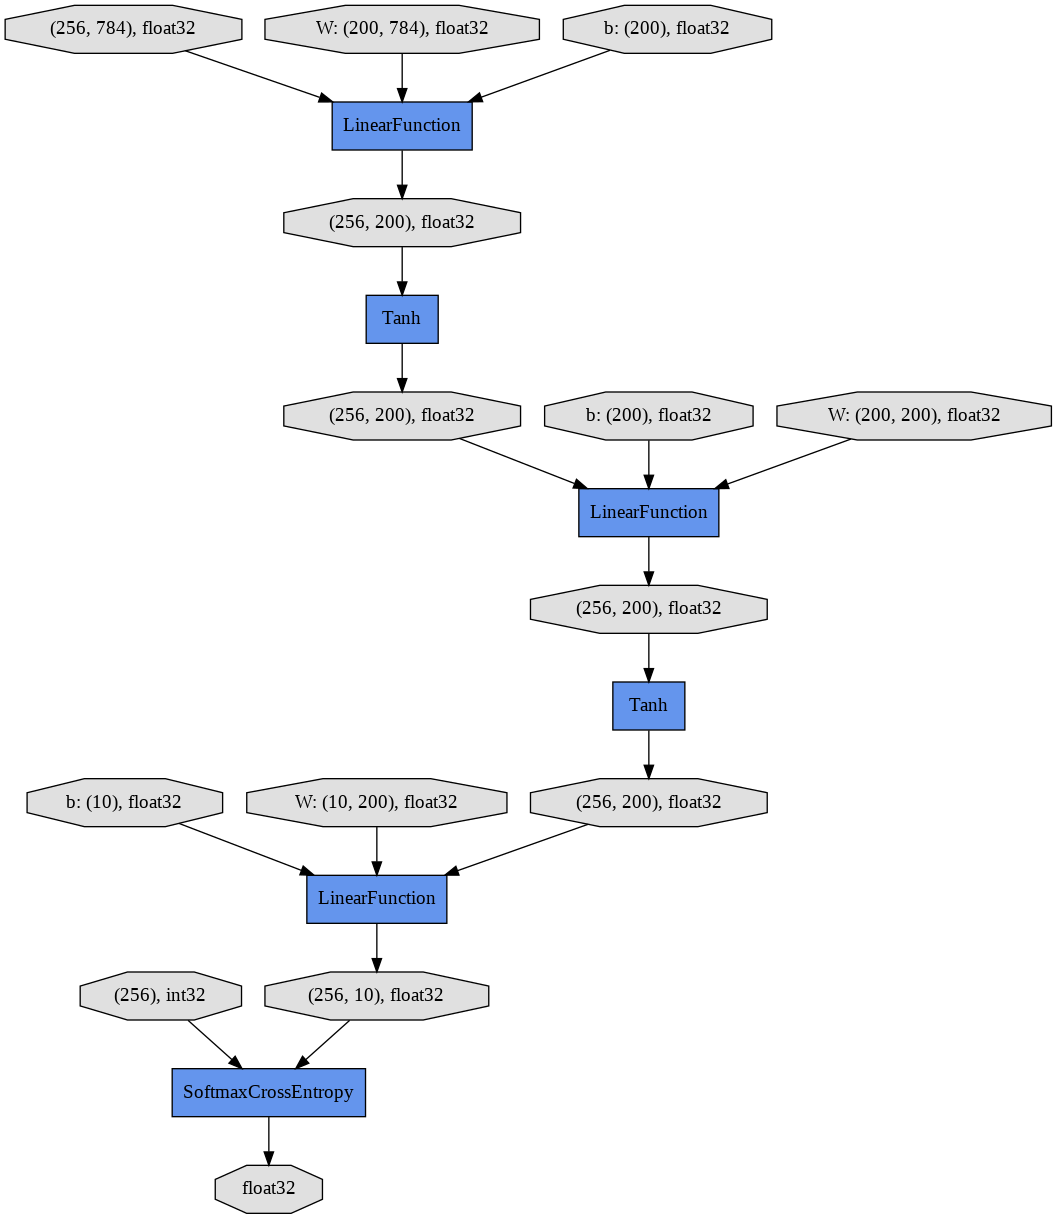

In [30]:
display_graph()

同様に、損失と精度もグラフとして表示してみましょう。

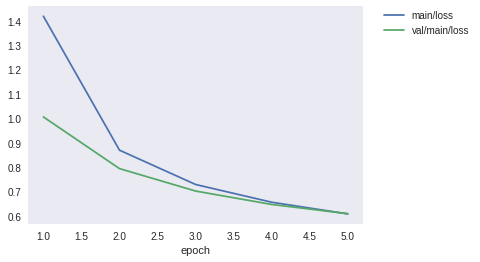

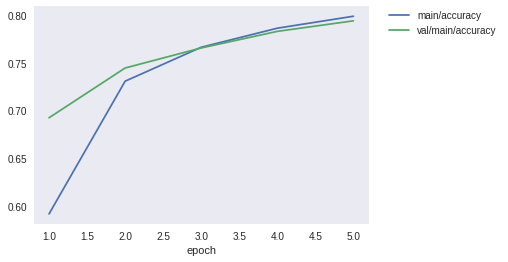

In [31]:
plot_loss_and_accuracy()

新しいモデルの分類結果はどうでしょうか。

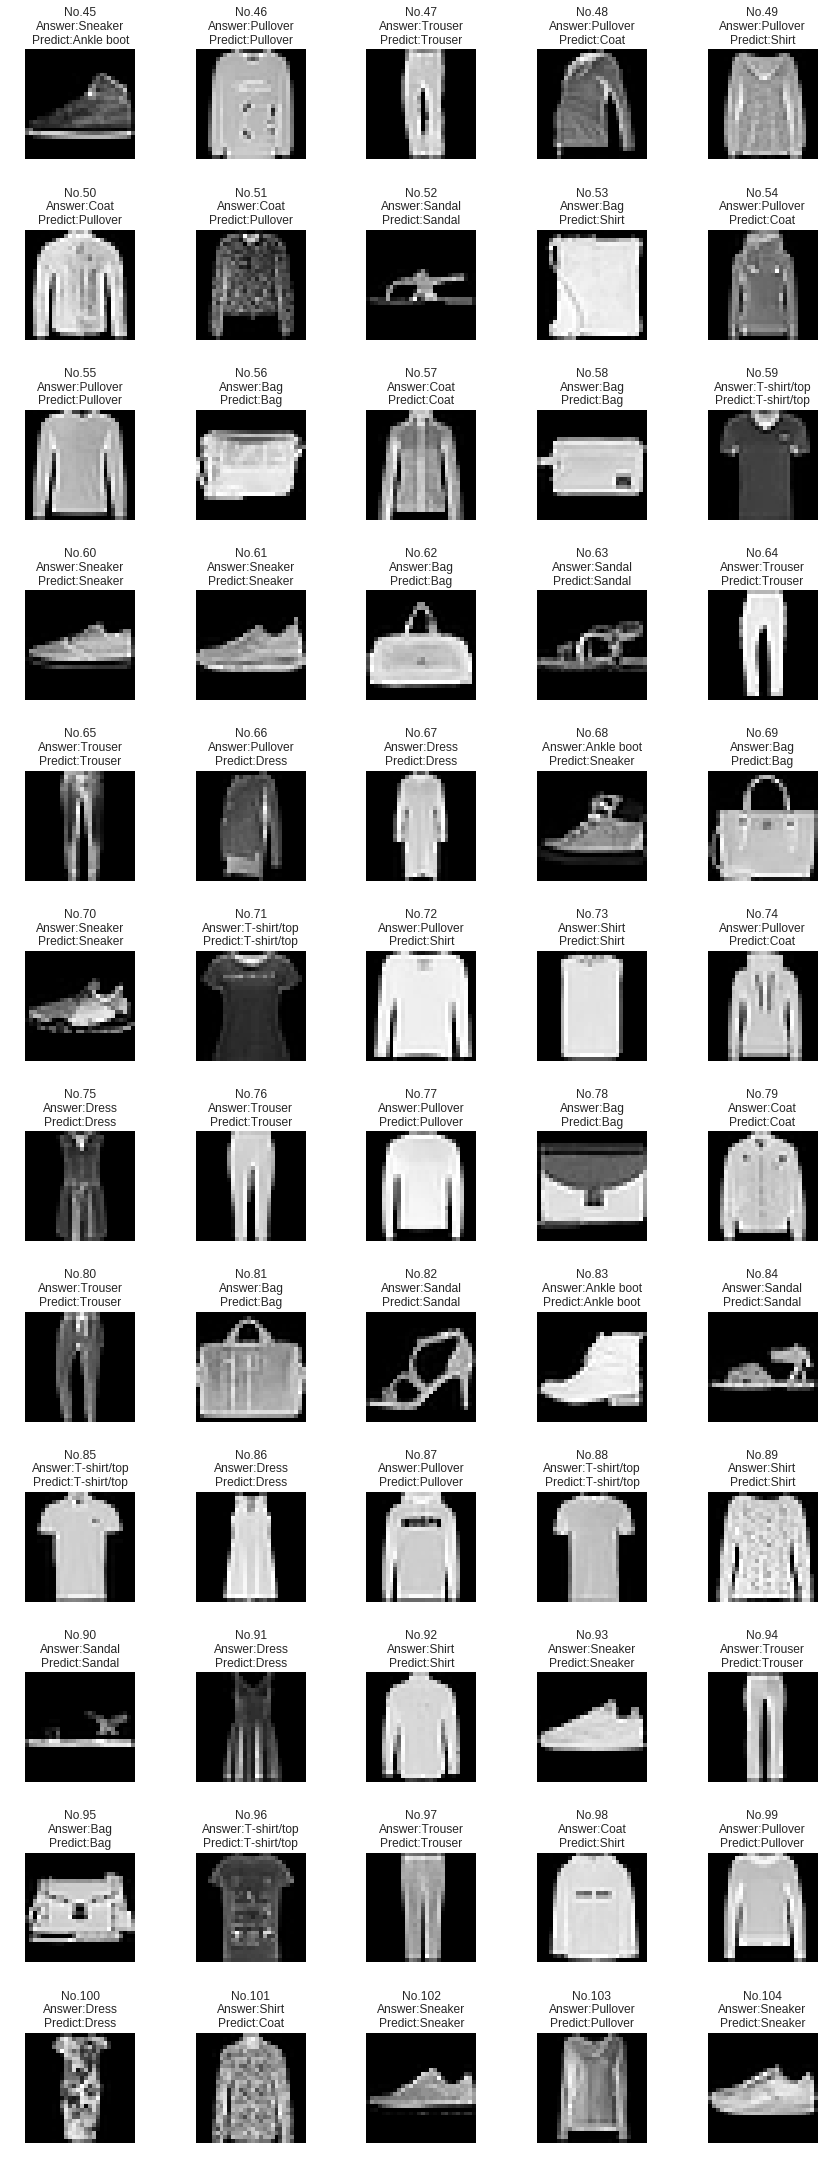

In [32]:
plot_examples(model, test, enable_cupy)

以前として、No. 45の画像を誤分類していますが、No. 72の画像は「Pullover」と正しく分類するようになりました。

### Chainerのモデルをデバッグしてみよう

Chainerの特長の１つとして、デバッグのしやすさが挙がります。
複雑なニューラルネットワークのデバッグは面倒です、なぜなら一般のフレームワークはモデル定義や実装のどこが間違っているのか、直接的には教えてくれない事が多いからです。しかし、Chainerでは普通のプログラムをデバッグするかのように行うことができ、順方向計算中の型チェックもサポートしています。

以下のMLP3Wrongは、MLP3に3つのバグをわざと埋め込んだものです。実行しながら1つ1つ解決してみましょう。

In [0]:
## Find three bugs in this model definition
class MLP3Wrong(Chain):

    def __init__(self):
        super(MLP3Wrong, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(748, 200)
            self.l2=L.Linear(200, 200)
            self.l3=L.Linear(200, 10)

    def __call__(self, x):
        h1 = F.tanh(self.l1(x))
        h2 = F.tanh(self.l2(x))
        y = self.l3(h3)
        return y

以下を実行するとエラーが発生しますが、スタックトレースの表示を下まで追うとそれが順方向計算においてどのソースコードのどの行で発生しているかがわかります。これはChainerのDefine-by-Runが、計算グラフを順方向計算中に直接構築しているため可能なことです。

In [34]:
enable_cupy = True
n_epoch = 5
batchsize = 256

model = MLP3Wrong()
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, enable_cupy, batchsize)

Exception in main training loop: 
Invalid operation is performed in: LinearFunction (Forward)

Expect: in_types[0].shape[1] == in_types[1].shape[1]
Actual: 784 != 748
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/trainer.py", line 316, in run
    update()
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/updaters/standard_updater.py", line 149, in update
    self.update_core()
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/updaters/standard_updater.py", line 160, in update_core
    optimizer.update(loss_func, *in_arrays)
  File "/usr/local/lib/python3.6/dist-packages/chainer/optimizer.py", line 650, in update
    loss = lossfun(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/chainer/links/model/classifier.py", line 134, in __call__
    self.y = self.predictor(*args, **kwargs)
  File "<ipython-input-33-8bed52cf443d>", line 11, in __call__
    h1 = F.tanh(self.l1(x))
  File "/usr/local/lib/p

InvalidType: ignored

3つのバグを修正し終わると、MLP3Wrongは先ほどのMLP3と一致するはずです。

#### 課題
- 上記モデルをデバッグして、正しいモデルに修正しましょう。

### 自分のモデルを作ってみよう
それではみなさんが試行錯誤して、モデルを改善する時間です。モデルを自分で変更してさらに高い精度を目指してみましょう。

エポック数を増やして時間をかけるのは単純過ぎる解決策なので、エポック数10以下、かつ訓練時間100秒以内という制限の中で、テスト用データにおいて88％を超える精度を達成してみてください。おすすめの方法としては、1つ1つのパラメータを変更してみて、その効果を確かめるのが良いでしょう。

例えば、モデルの変更可能なオプションは以下があるでしょう。

* 各ユニットのノード数を増やす
* レイヤー数を増やす
* 異なる活性化関数を用いる

In [0]:
## Let's create new Multi-Layer Perceptron (MLP)
class MLPNew(Chain):

    def __init__(self):
        # Add more layers?
        super(MLPNew, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)  # Increase output node as (784, 300)?
            self.l2=L.Linear(200, 200)  # Increase nodes as (300, 300)?
            self.l3=L.Linear(200, 10)      # Increase nodes as (300, 10)?

    def __call__(self, x):
        h1 = F.tanh(self.l1(x))        # Replace F.tanh with F.sigmoid  or F.relu ?
        h2 = F.tanh(self.l2(h1))        # Replace F.tanh with F.sigmoid  or F.relu ?
        y = self.l3(h2)
        return y

学習方法の変更可能なオプションは以下があるでしょう。

* エポック数を増やす
* ミニバッチサイズを増やす/減らす
* Optimizerを変更する

In [0]:
enable_cupy = True
n_epoch = 5  # Add more epochs?
batchsize = 256  # Increse/Decrese mini-batch size?

model = MLPNew() 
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()  # Use other optimizer, Adam()?

訓練と検証を行って、まずは検証用データで目標の性能を達成する確認しましょう。

In [37]:
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, enable_cupy, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.43226     0.585698       1.02465        0.676855           1.55142       
2           0.883469    0.715124       0.80664        0.726465           3.34899       
3           0.738899    0.755329       0.711514       0.758203           5.28916       
4           0.6641      0.778978       0.655403       0.777051           7.27428       
5           0.615054    0.793069       0.614993       0.788477           9.36055       


損失や精度を可視化することで目標を達成できそうかも確認できます。

例えば、「検証用データの精度``val/main/accuracy``が順調に上昇していれば目標を達成できそう」「検証用データの精度``val/main/accuracy``が早い段階で頭打ちになっているからこれだと無理だ」などです。

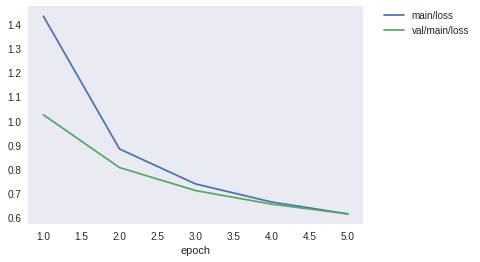

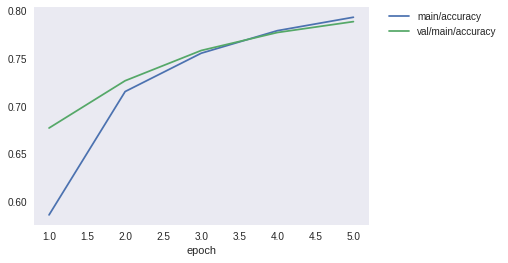

In [38]:
plot_loss_and_accuracy()

検証用データで達成したことを確認できたら、以下を実行してテスト用データでの性能を確認しましょう。

どうでしょうか、テスト用データでも目標を達成できたでしょうか。

In [39]:
print_test_performance(classifier_model, test, enable_cupy, batchsize)

Test accuracy: 0.7879883


計算グラフを表示することで、想定通りのモデルが定義されているか確認することができます。

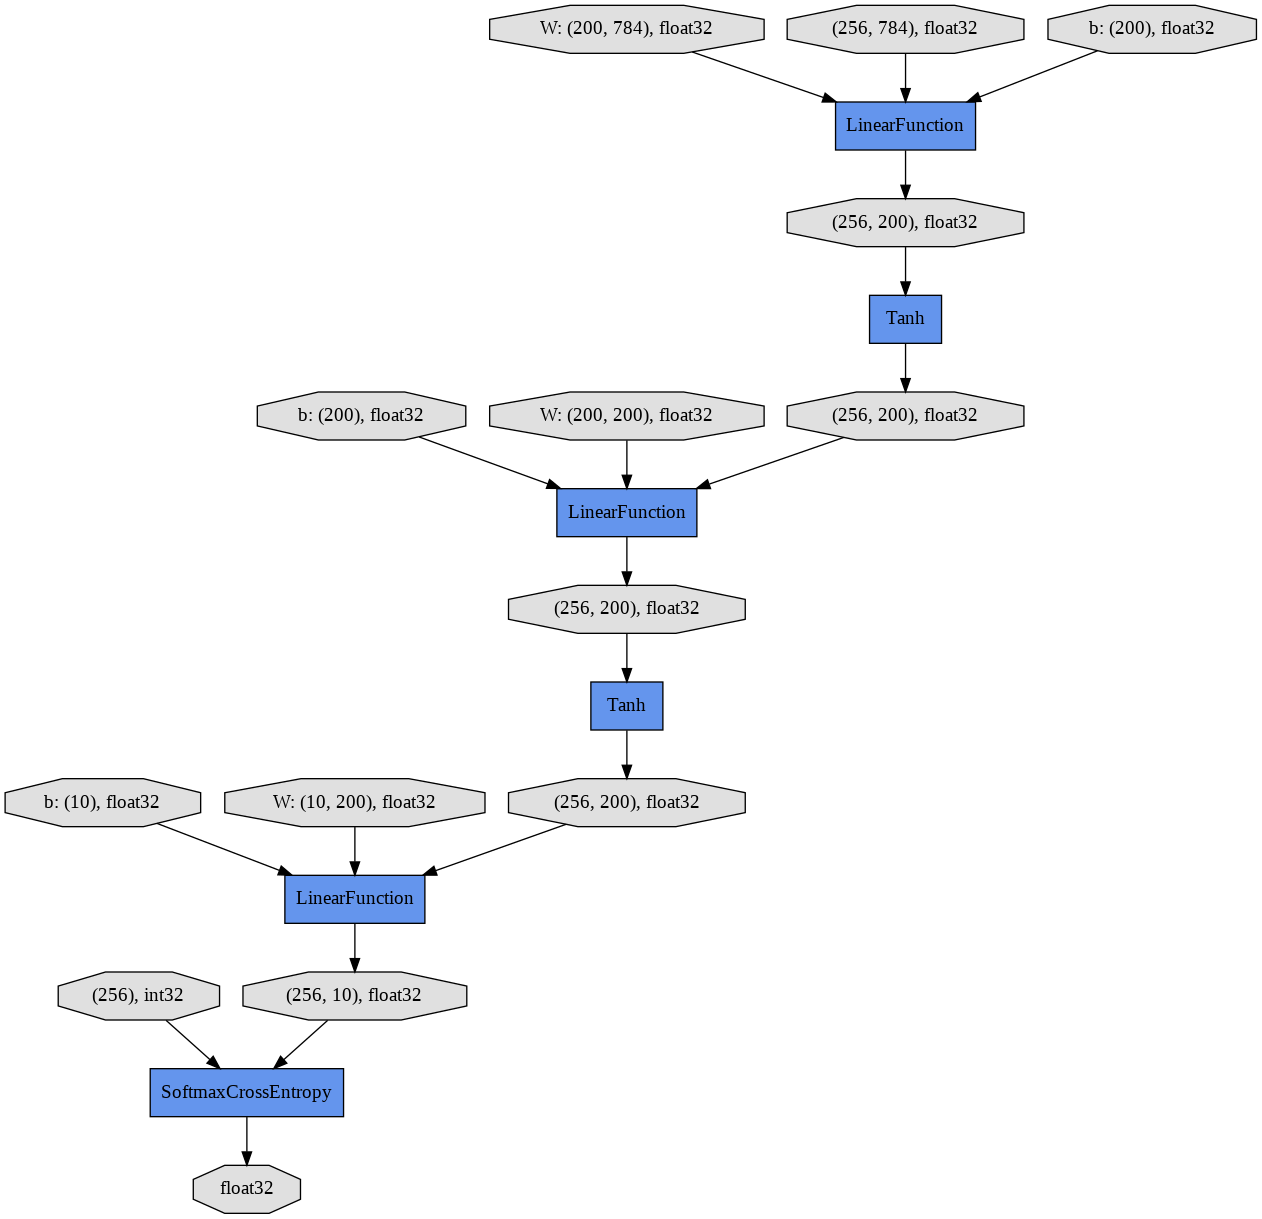

In [40]:
display_graph()

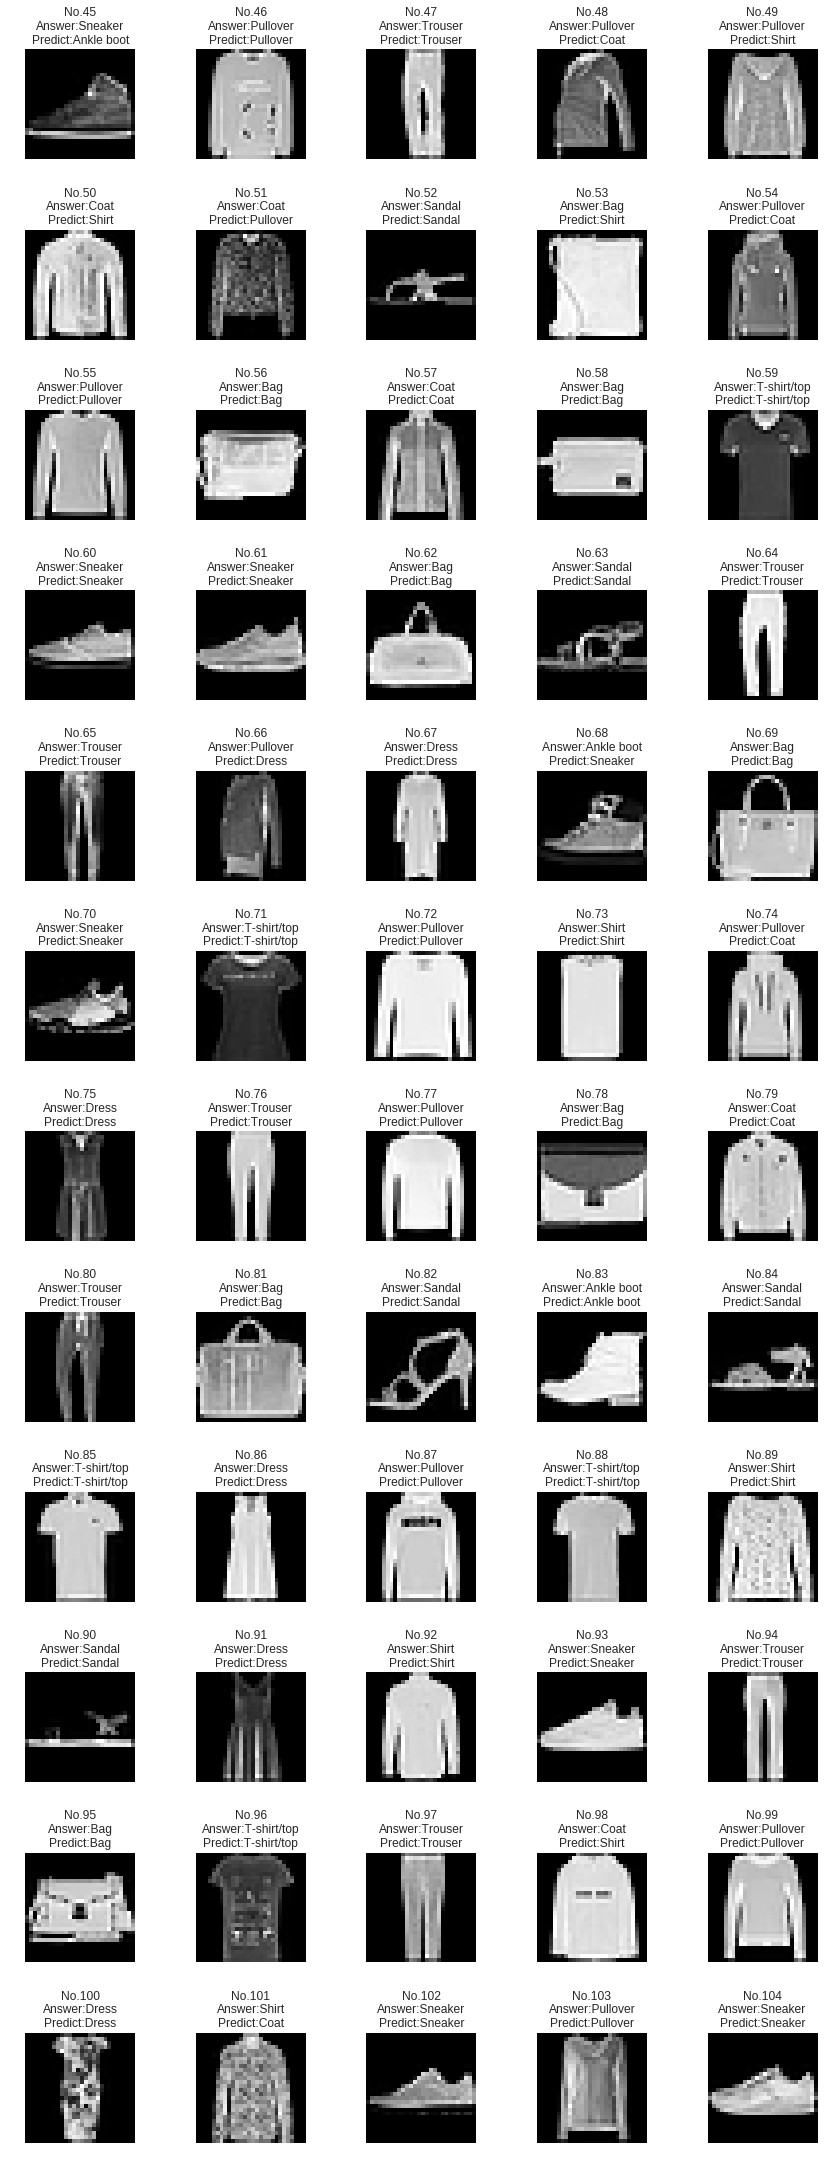

In [41]:
plot_examples(model, test, enable_cupy)

#### 課題
[LeNet5](http://yann.lecun.com/exdb/lenet/)というモデルを以下に示します。このモデルは、3つの畳み込み(convolution)層と、2つの全結合層を持つ計5層のネットワークです。

- これを元に以下の条件で精度90%以上を達成しましょう。

    1. エポック数30以下
    2. 訓練時間200秒以内

In [0]:
class LeNet5(Chain):
    def __init__(self):
        super(LeNet5, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=6, ksize=5, stride=1)
            self.conv2 = L.Convolution2D(
                in_channels=6, out_channels=16, ksize=5, stride=1)
            self.conv3 = L.Convolution2D(
                in_channels=16, out_channels=120, ksize=4, stride=1)
            self.fc4 = L.Linear(None, 84)
            self.fc5 = L.Linear(84, 10)

    def __call__(self, x):
        h = F.sigmoid(self.conv1(x.reshape((-1, 1, 28, 28))))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv3(h))
        h = F.sigmoid(self.fc4(h))
        return self.fc5(h)
        return F.softmax(self.fc5(h))

In [49]:
enable_cupy = True
n_epoch = 10
batchsize = 256

model = LeNet5()
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, enable_cupy, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           2.05377     0.260423       1.28244        0.559668           2.75333       
2           1.00115     0.635096       0.858261       0.694629           5.64859       
3           0.7625      0.718309       0.733227       0.718262           8.57283       
4           0.676382    0.741171       0.679334       0.728516           11.5541       
5           0.6335      0.751522       0.639954       0.74082            14.4819       
6           0.597471    0.764343       0.60291        0.758496           17.4276       
7           0.568454    0.775889       0.582357       0.768848           20.3863       
8           0.544411    0.786759       0.550212       0.780762           23.3268       
9           0.523618    0.795974       0.546116       0.778613           26.35         
10          0.506361    0.804269       0.519479       0.795215           29.3089       


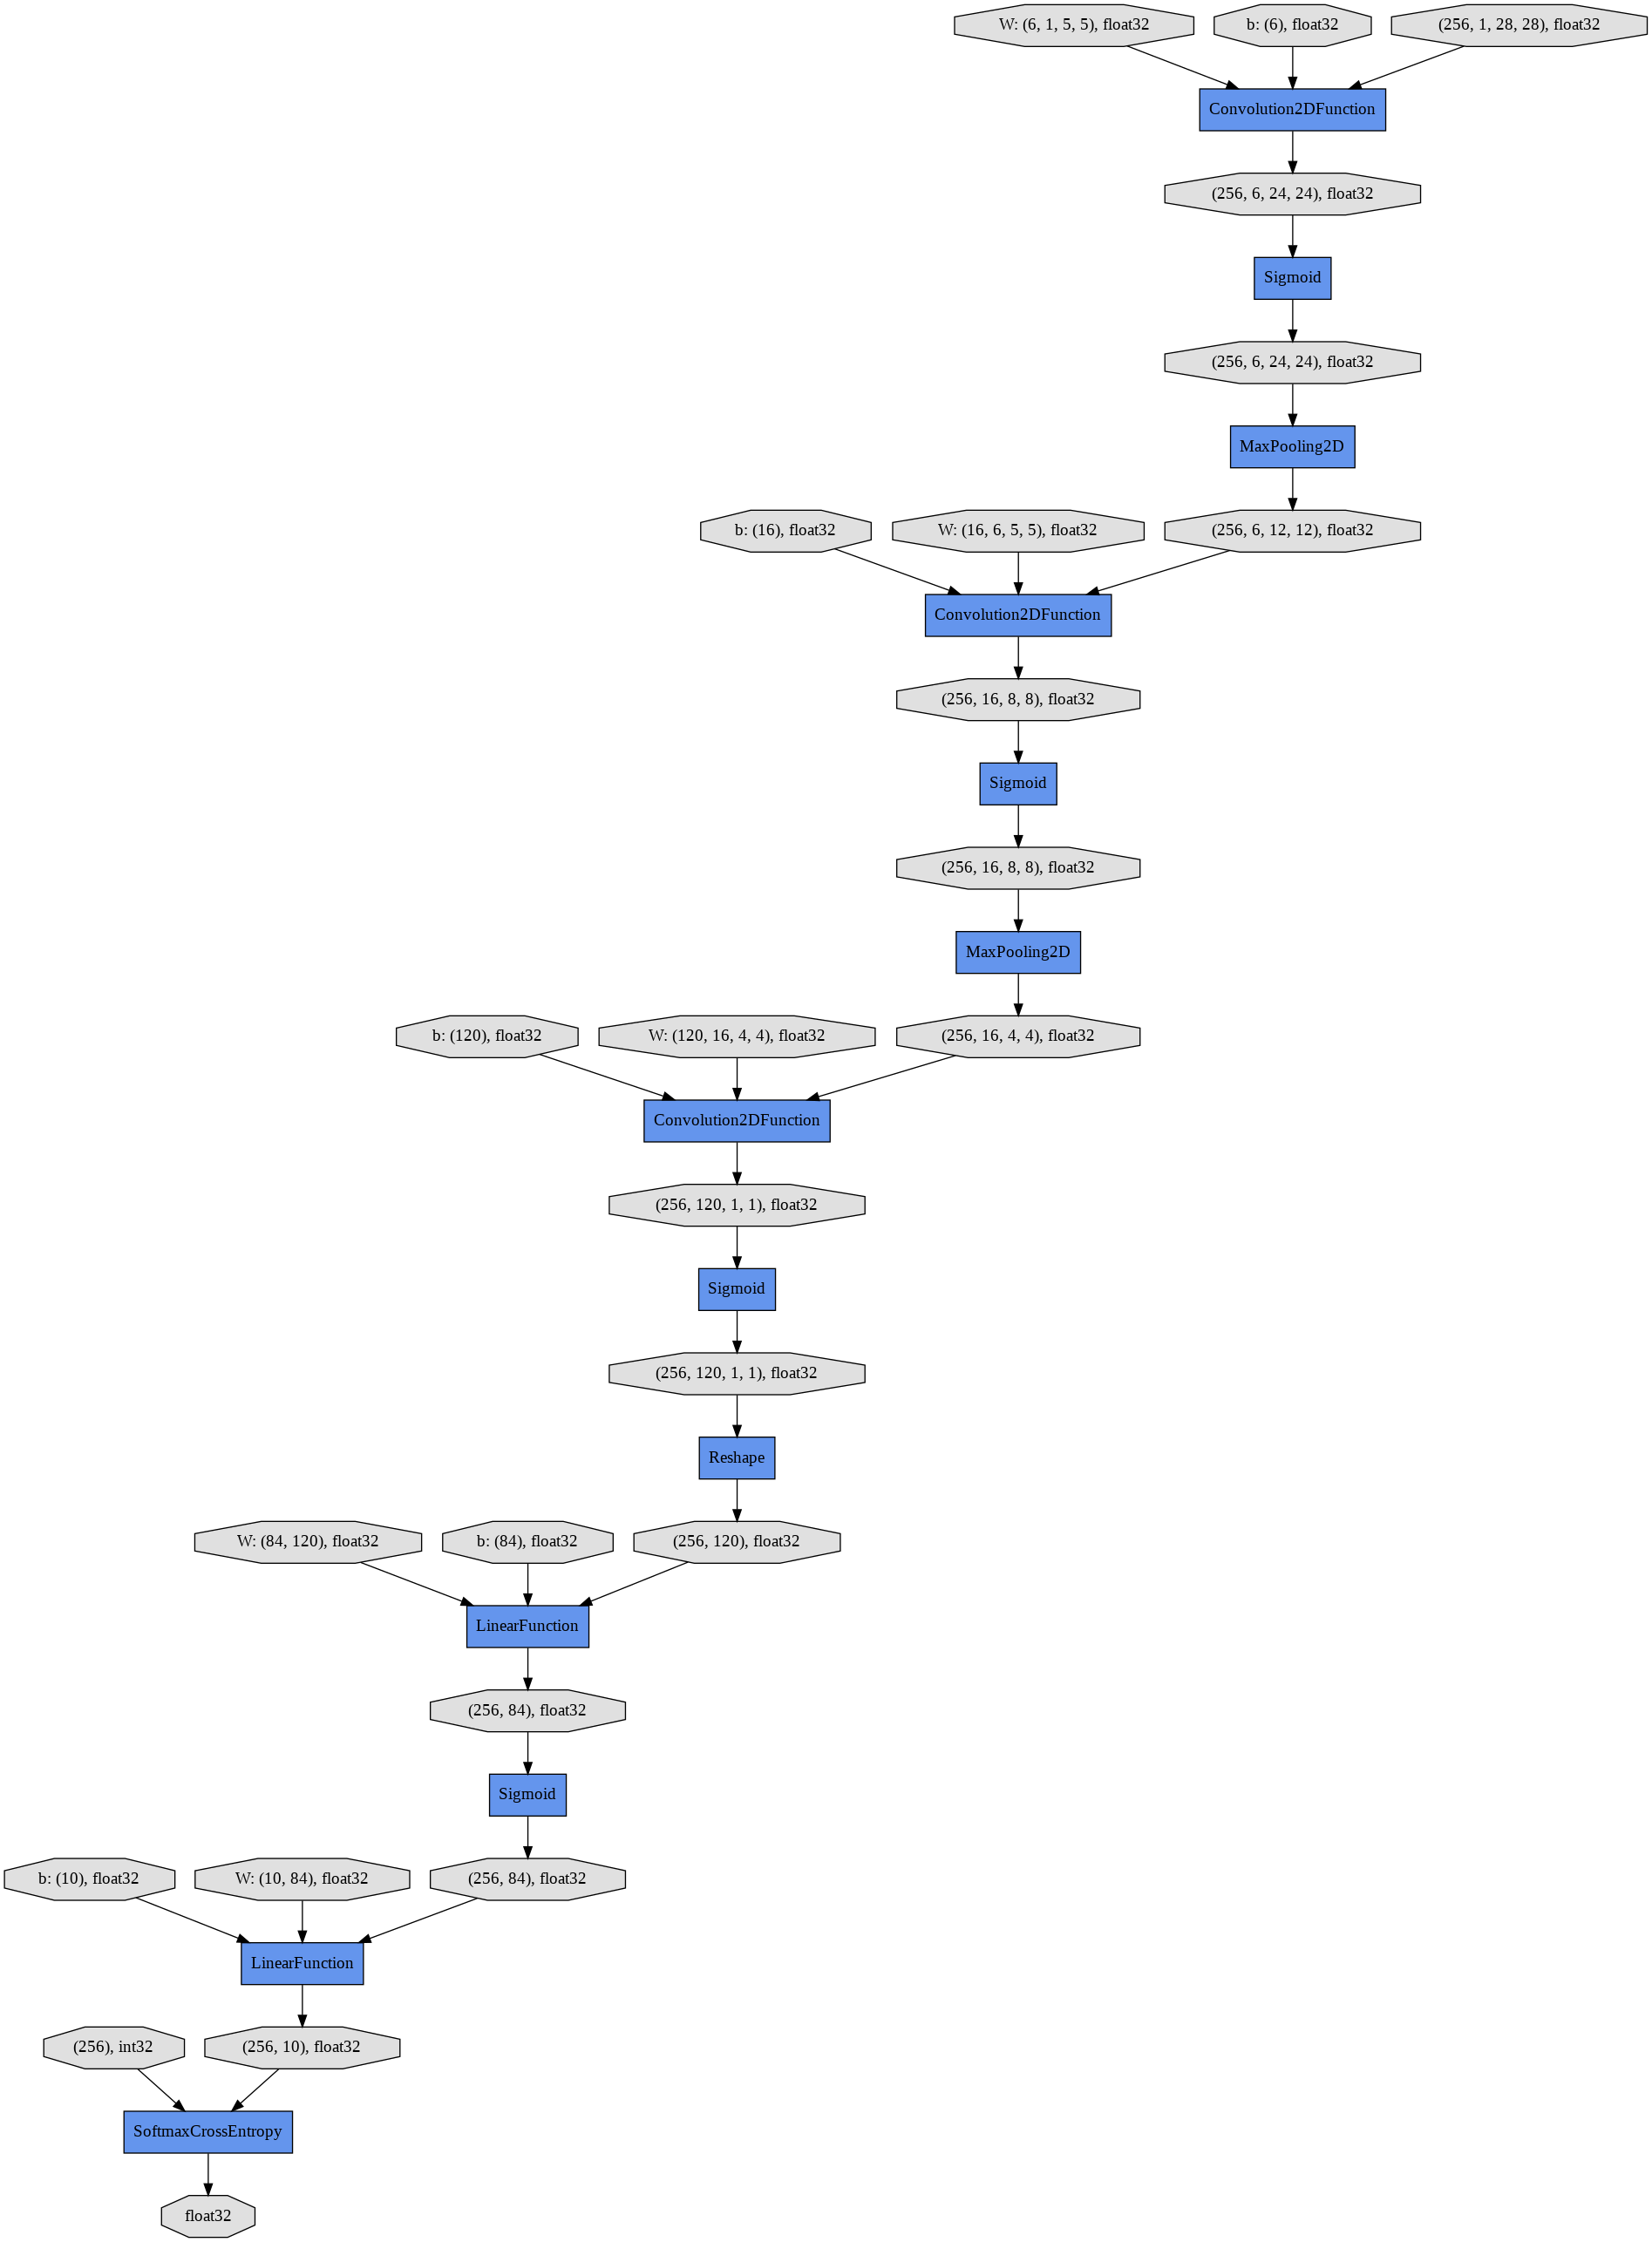

In [50]:
display_graph()

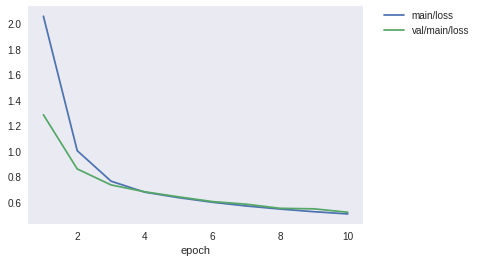

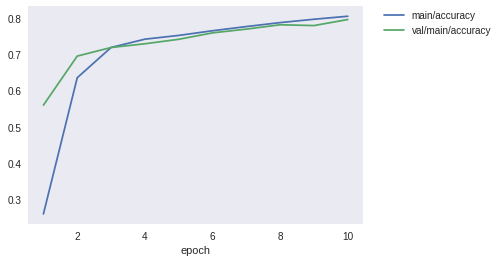

In [51]:
plot_loss_and_accuracy()

In [53]:
print_test_performance(classifier_model, test, enable_cupy, batchsize)

Test accuracy: 0.8023437


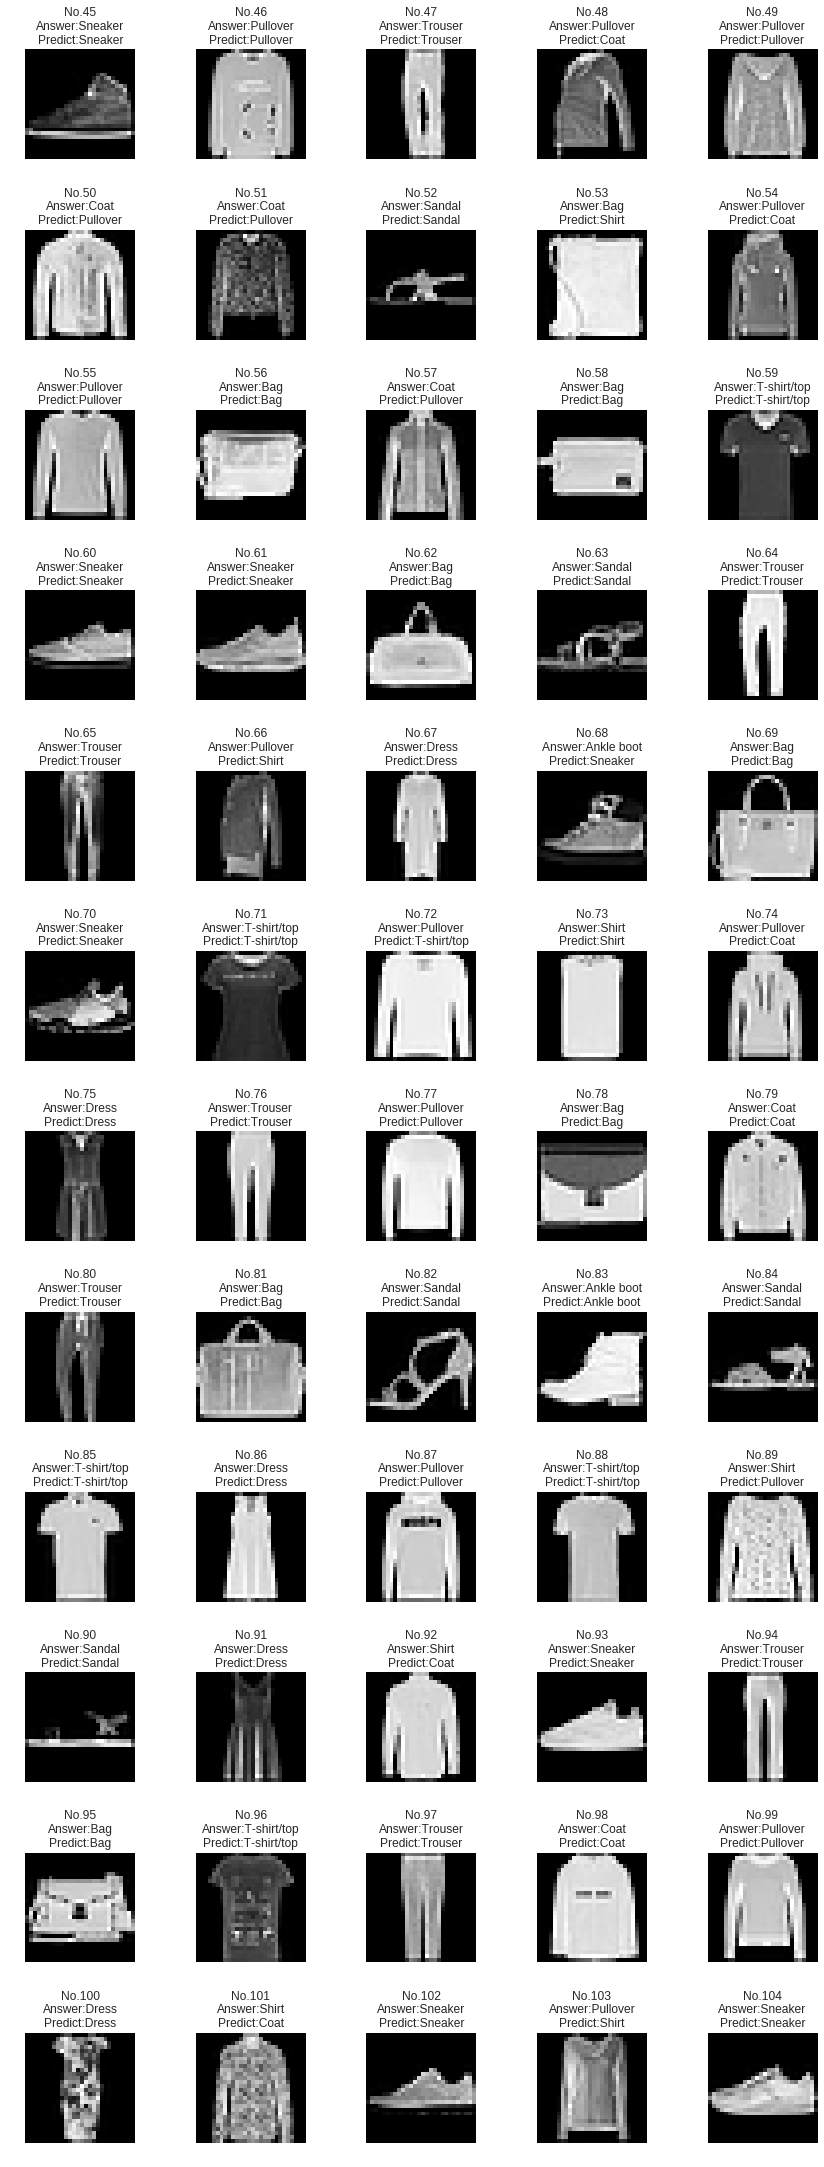

In [54]:
plot_examples(model, test, enable_cupy)

#### 課題
- 上記の課題では、まだ説明していないものを使っています。下記の言葉がどのような意味か調べて、説明を書いてみましょう。

    1. 畳み込み(convolution)層
    2. プーリング(pooling)層
    3. チャネル(channel)
    
次回のハンズオンでは、この課題の復習から始めようと思いますので、楽しみにしていてください。